# Cifar10 classification case study with novel class

**Goal:** In this you will investigate which advantages Bayesian NNs can offer in a classification task. You will use train data from 9 of the 10 classes in the Cifar10 dataset to fit different three probabilistic NN.
First you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via variational inference and one via dropout. You will compare the accuracy of the different NN on the 9 known classes. Further you will investigate and compare the uncertainties expressed by the NNs for bothm the known classes and unknown class. Finally you will use these uncertainties to detect novel classes and filter uncertain predictions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"). You will delete all iamges from the class "horse" in the training dataset to simulate a novel class. Note that we keep the class "horse" in the test dataset.

**Content:**
* Load the Cifar10 dataset
* Delete all iamges of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the 
* Plot the testdata along with the predicted mean and the 2.5% and 97.5% percentiles of the predicted CPD
* Compare the different models based on the test NLL 

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_02.ipynb)

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
      !pip install tensorflow-gpu==2.0.0
      !pip install tensorflow-probability==0.8.0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')


print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


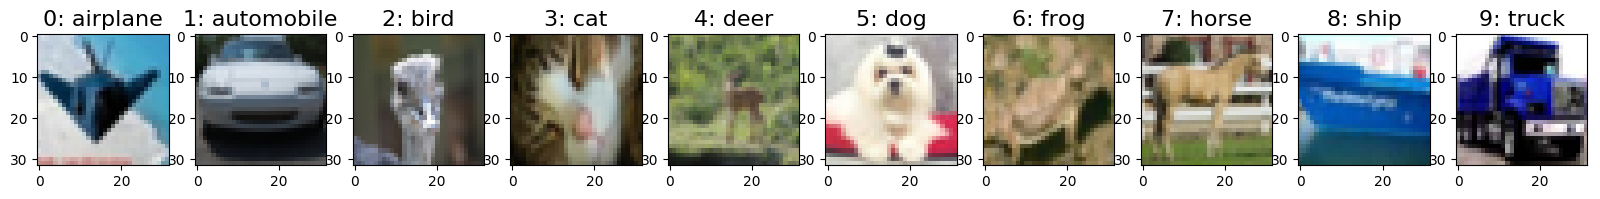

In [5]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
from google.colab import files
files.download('Figure_8_cifar.pdf') 


In [0]:
#we delete all horses of the dataset
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)

In [7]:
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)


In [0]:
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])


In [9]:
print(y_train_no_horse.shape)

(45000, 9)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)


In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Baseline "normal" CNN

In [13]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________

In [0]:
# history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=50,verbose=1)
# nach  30 epochs overfitting

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

## Variational Inference

In [17]:


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model_vi = Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_______________________________________________

In [18]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.1292094  0.0985678  0.10017236 0.13528724 0.13537641 0.11324198
 0.10947141 0.08488081 0.09379259]
[0.1303243  0.14451225 0.07229606 0.09723387 0.1535432  0.11429546
 0.06231025 0.09763279 0.1278518 ]
[0.06689023 0.15751913 0.04825068 0.15041865 0.0739176  0.21081503
 0.09103224 0.13689801 0.06425841]
[0.14356838 0.13585916 0.10156395 0.06515636 0.1188993  0.15616001
 0.11436813 0.10118981 0.06323488]
[0.1680659  0.1150012  0.07249018 0.10116985 0.11873175 0.13118453
 0.11850856 0.09265345 0.08219454]


In [0]:
# history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)
# need a lot of epochs
# longer training would maybe give some improvement

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi_cifar10_weights.hdf5", "model_vi_cifar10_weights.hdf5")
model_vi.load_weights("model_vi_cifar10_weights.hdf5")

## MC Dropout

In [22]:
#def MCDropout(rate):
#    return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

model_mc = Sequential()
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(9, activation = 'softmax'))

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)       

In [0]:
import tensorflow.keras.backend as K
#f = K.function([model_mc.input], [model_mc.output])
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])



In [24]:
#no dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.11121761 0.1109796  0.11485801 0.10617814 0.10407332 0.12229758
  0.10401902 0.11076756 0.11560924]]
[[0.11121761 0.1109796  0.11485801 0.10617814 0.10407332 0.12229758
  0.10401902 0.11076756 0.11560924]]
[[0.11121761 0.1109796  0.11485801 0.10617814 0.10407332 0.12229758
  0.10401902 0.11076756 0.11560924]]
[[0.11121761 0.1109796  0.11485801 0.10617814 0.10407332 0.12229758
  0.10401902 0.11076756 0.11560924]]
[[0.11121761 0.1109796  0.11485801 0.10617814 0.10407332 0.12229758
  0.10401902 0.11076756 0.11560924]]


In [25]:
#dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],1])[0])

[[0.09859519 0.11091562 0.1058234  0.09521022 0.08448742 0.13060707
  0.07468648 0.16007577 0.13959883]]
[[0.09140249 0.10951918 0.08429644 0.11643861 0.0873773  0.14250778
  0.08357742 0.12308791 0.16179281]]
[[0.11797568 0.08654574 0.14398132 0.11412536 0.11541913 0.1698155
  0.08868609 0.09776714 0.06568401]]
[[0.12833333 0.08697507 0.1273753  0.09271599 0.11207243 0.13427876
  0.15820256 0.07621712 0.08382944]]
[[0.11615387 0.10423294 0.08120975 0.10216762 0.08698391 0.15361105
  0.07555563 0.14000903 0.14007616]]


In [0]:
#history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", "model_mc_cifar10_weights.hdf5")
model_mc.load_weights("model_mc_cifar10_weights.hdf5")

## Acc on the lables in the train set for all three models
VI and MC 50 preds und then argmax of mean

In [29]:
known_idx=np.where(y_test!=7)[0]
print(len(known_idx))
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

unknown_idx=np.where(y_test==7)[0]
print(len(unknown_idx))
x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

9000
1000


In [30]:
pred_baseline=np.argmax(model.predict(x_test_known),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred_baseline[i])] for i in range(0,len(pred_baseline))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6632222222222223


In [31]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred_vi=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class

In [32]:
pred_label=np.array([labels_no_horse[np.int(pred_vi[i])] for i in range(0,len(pred_vi))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_vi = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6788888888888889


In [33]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred_mc=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class

In [34]:
pred_label=np.array([labels_no_horse[np.int(pred_mc[i])] for i in range(0,len(pred_mc))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_mc = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.7188888888888889


In [35]:
import pandas as pd
pd.DataFrame(np.column_stack([test_acc_known,test_acc_known_vi,test_acc_known_mc]), index=['test acc on known labels'],columns=['baseline','VI','MC'])

,baseline,VI,MC
test acc on known labels,0.663222,0.678889,0.718889


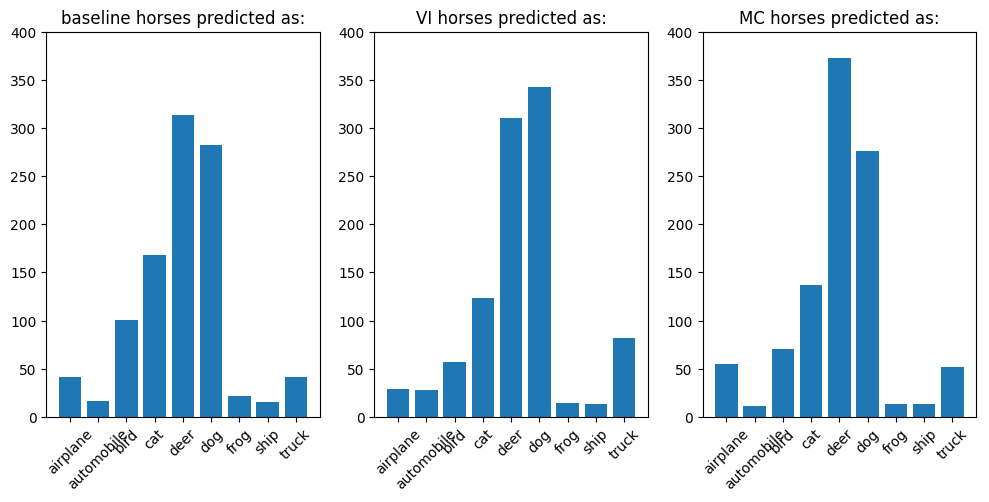

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pred=np.argmax(model.predict(x_test_unknown),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("baseline horses predicted as:")
plt.ylim([0,400])

plt.subplot(1,3,2)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI horses predicted as:")
plt.ylim([0,400])

plt.subplot(1,3,3)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC horses predicted as:")
plt.ylim([0,400])
plt.show()

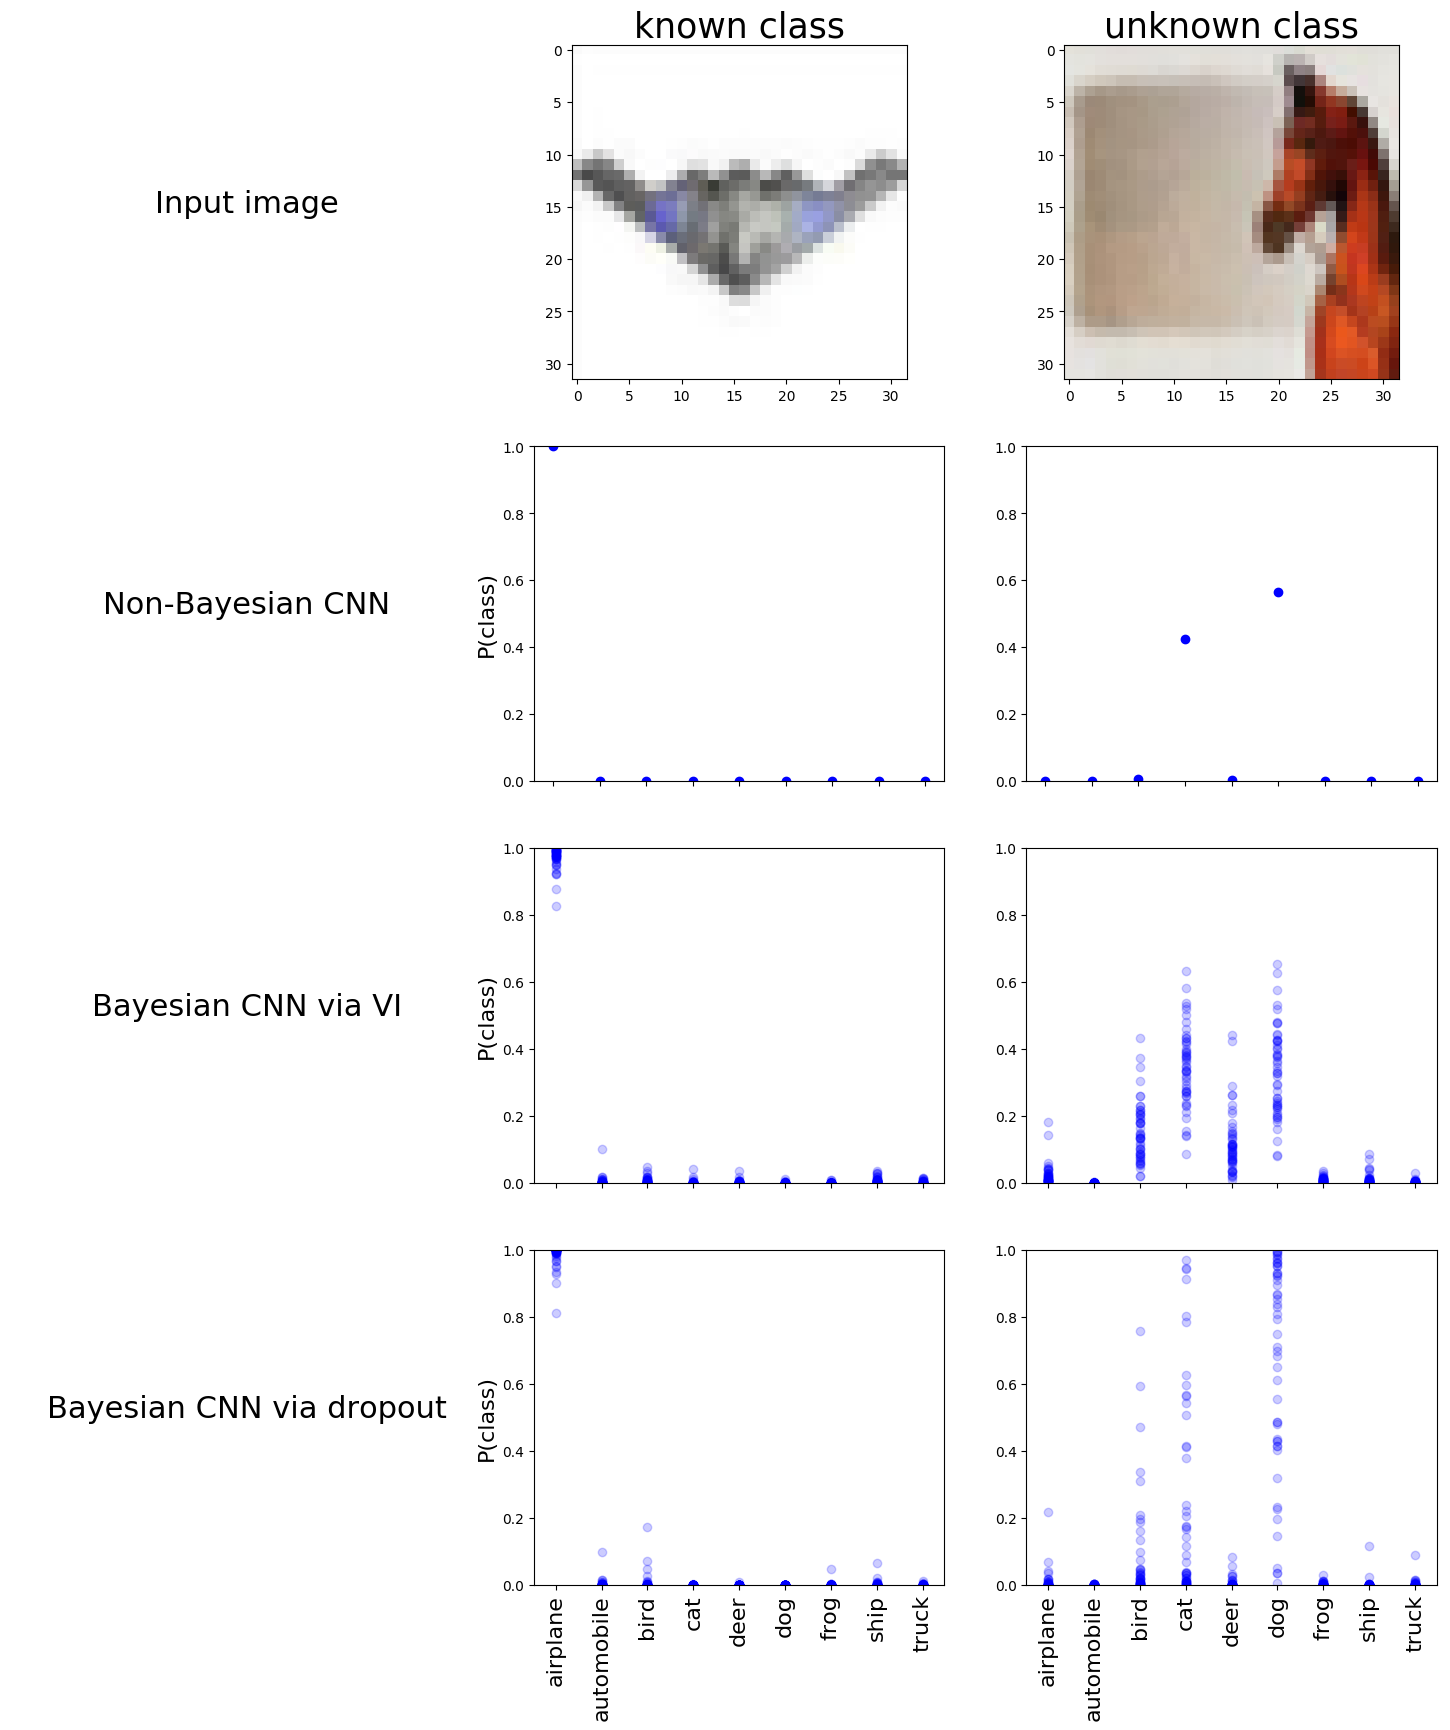

In [37]:
np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,20))
plt.subplot(4,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(4,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(4,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(4,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,9)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,11)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,12)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
#plt.show()
plt.savefig("Figure_8_good2.pdf")
from google.colab import files
files.download('Figure_8_good2.pdf') 

In [43]:
pred=model.predict(x_test_unknown)
pred_uk=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))]) #Numerical Stability
#pred.shape

[2.101216,
 1.279239,
 2.5482821,
 0.5335326,
 1.3721344,
 1.4432248,
 1.3279238,
 2.7494166,
 1.9414037,
 2.3526978,
 2.5798285,
 0.09609606,
 0.706699,
 2.1262376,
 2.411993,
 2.3239655,
 2.4984665,
 1.2931036,
 1.3886157,
 1.8504336,
 0.9552773,
 1.9033881,
 1.6227039,
 2.3864493,
 1.6472498,
 1.6091172,
 1.4472803,
 1.9377096,
 2.0569272,
 2.134844,
 2.89113,
 0.9088012,
 2.344393,
 2.6427383,
 1.2330351,
 1.2583559,
 1.7570943,
 0.5847463,
 2.158309,
 2.0218604,
 1.096094,
 1.5129238,
 2.3132966,
 2.223701,
 0.8277225,
 2.4603555,
 2.1763287,
 2.6315503,
 1.8590999,
 2.8865836,
 1.6302998,
 1.2055004,
 1.5332315,
 1.7190957,
 0.723584,
 1.0407506,
 0.100920014,
 1.3595518,
 2.1459851,
 1.8106623,
 0.72406226,
 0.3475976,
 0.09409245,
 0.7979907,
 1.1299672,
 2.2654595,
 1.8072072,
 2.2649894,
 2.5303888,
 2.319497,
 2.384148,
 1.8196354,
 2.0731628,
 1.4647263,
 1.5383025,
 0.9012769,
 0.30456558,
 0.8960051,
 1.9202452,
 1.9078519,
 1.7151614,
 2.525418,
 0.30112135,
 1.1708727,


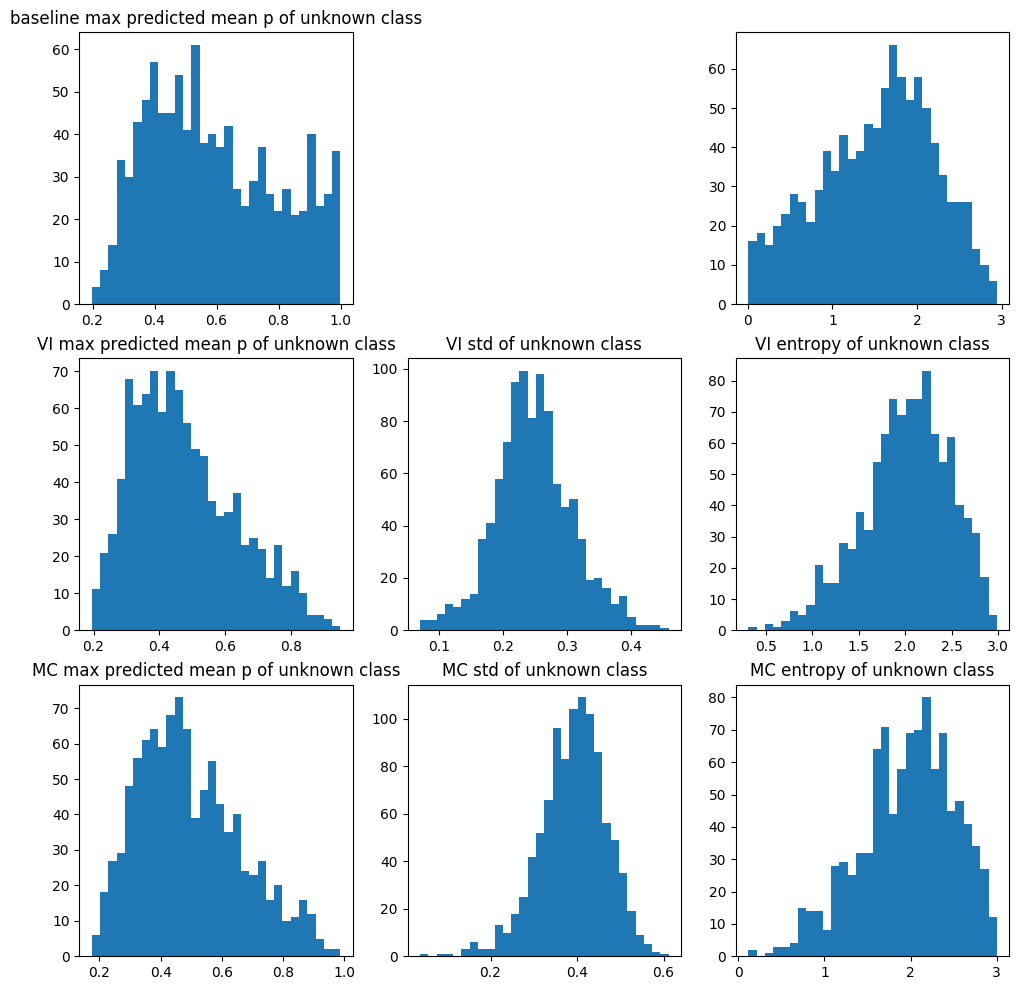

In [49]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

pred=model.predict(x_test_unknown)
pred_uk=np.max(pred,axis=1)
entropy_uk=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])


plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of unknown class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.hist(entropy_uk,bins=30)
plt.title("baseline entropy of unknown class")

SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of unknown class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of unknown class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of unknown class")



SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means_uk[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of unknown class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of unknown class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of unknown class")
plt.show()


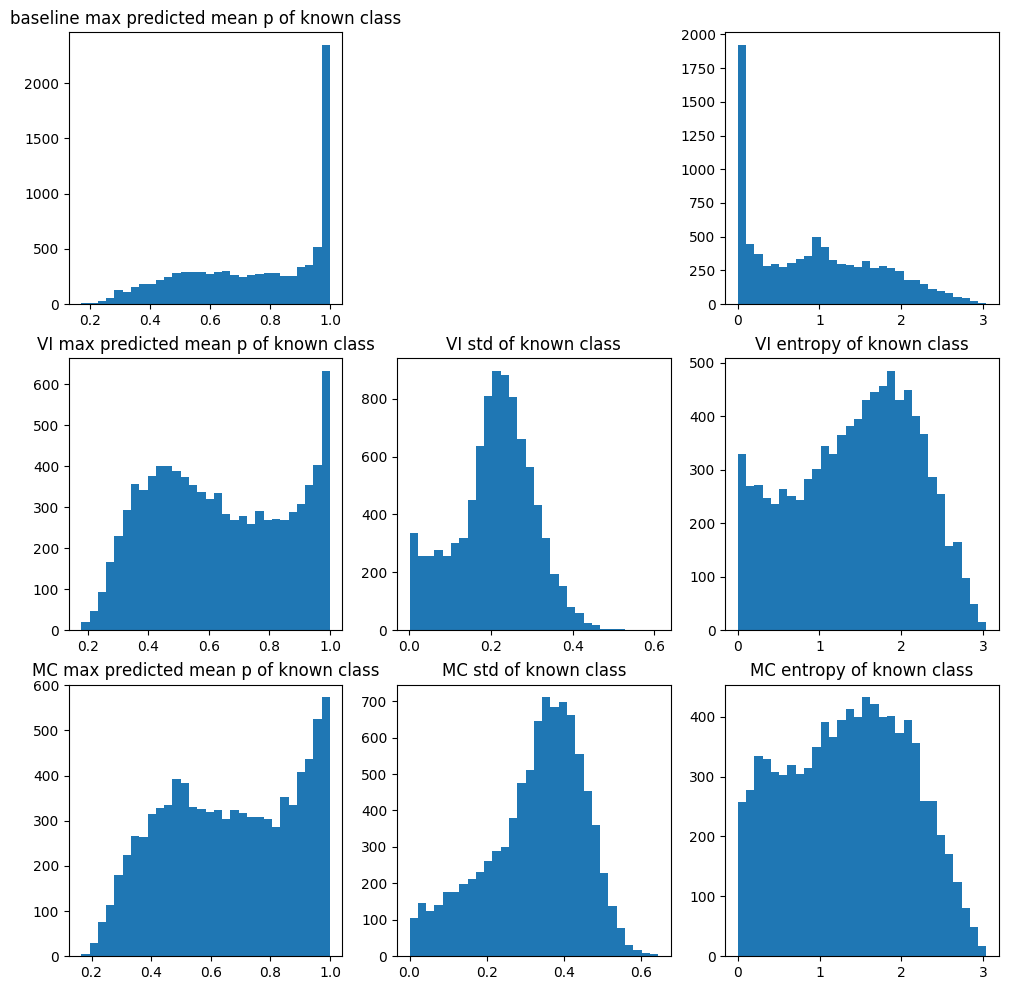

In [50]:
## look at the means sd and entropy of the known classes of the testset,
## here we want to see a low uncertainty

pred=model.predict(x_test_known)
pred_uk=np.max(pred,axis=1)
entropy_uk=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of known class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.hist(entropy_uk,bins=30)
plt.title("baseline entropy of known class")

SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of known class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of known class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of known class")



SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means_uk[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of known class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of known class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of known class")
plt.show()


In [65]:
nr_of_best=5000






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


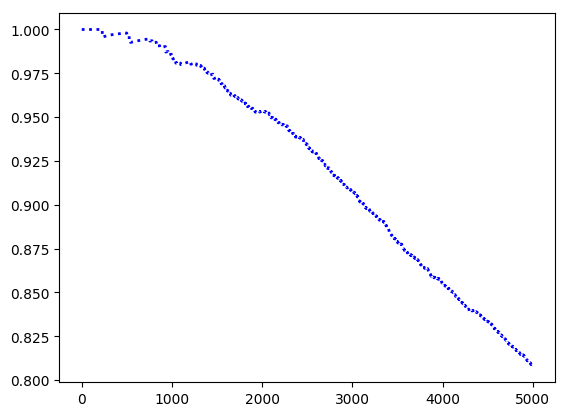

In [74]:
acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)

In [72]:
acc_nbest[0:10]

array([nan,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [0]:
certainty_idx = np.argsort(pred.reshape(len(pred)))

In [56]:
pred_std_uk.shape

(9000, 1)

In [59]:
np.argsort(pred_std_uk.reshape(len(pred_std_uk)))

array([1656, 2615, 5186, ...,  221, 1518,  663])

## Filter our preds with pmax and p_mean

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in long_scalars


MessageError: ignored

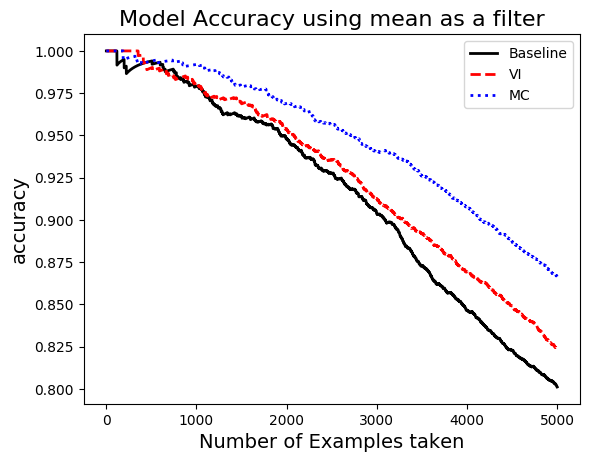

In [78]:
nr_of_best=5000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse

pred=model.predict(x_test)
acc_nbest = np.zeros((nr_of_best))
for j in tqdm(range(0,nr_of_best)):
  pred_am=np.argmax(pred[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=np.sum(pred_label==true_label)/len(pred_label)

plt.plot(acc_nbest,c="black",linewidth=2)
plt.title('Model Accuracy using mean as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse


acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)



SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse


acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Baseline', 'VI',"MC"], loc='upper right')
#plt.show()
plt.savefig("Figure_8_filter_vi_mc.pdf")
from google.colab import files
files.download('Figure_8_filter_vi_mc.pdf')


In [0]:
files.download('Figure_8_filter_vi_mc.pdf')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in long_scalars


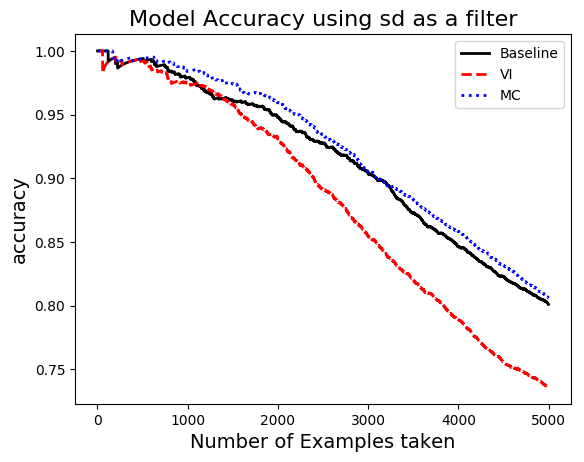

In [80]:
nr_of_best=5000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse

pred=model.predict(x_test)
acc_nbest = np.zeros((nr_of_best))
for j in tqdm(range(0,nr_of_best)):
  pred_am=np.argmax(pred[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=np.sum(pred_label==true_label)/len(pred_label)

plt.plot(acc_nbest,c="black",linewidth=2)
plt.title('Model Accuracy using sd as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)




SET=x_test
pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))
entropy = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred_std.reshape(len(pred_std)))

acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)


SET=x_test
pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))
entropy = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred_std.reshape(len(pred_std)))


acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Baseline', 'VI',"MC"], loc='upper right')
#plt.show()
plt.savefig("Figure_8_filter_vi_mc_with_sd.pdf")






In [0]:
from google.colab import files
files.download('Figure_8_filter_vi_mc_with_sd.pdf')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in long_scalars


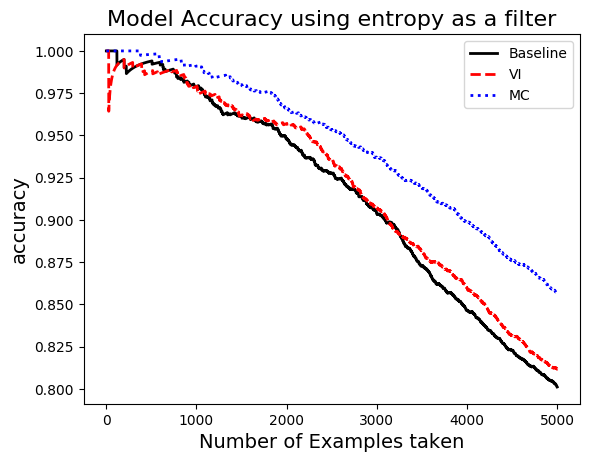

In [84]:
nr_of_best=5000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse

pred=model.predict(x_test)
acc_nbest = np.zeros((nr_of_best))
for j in tqdm(range(0,nr_of_best)):
  pred_am=np.argmax(pred[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=np.sum(pred_label==true_label)/len(pred_label)

plt.plot(acc_nbest,c="black",linewidth=2)
plt.title('Model Accuracy using entropy as a filter',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('Number of Examples taken',fontsize=14)




SET=x_test
pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))
entropy = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(entropy.reshape(len(entropy)))

acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="red",linestyle="dashed",linewidth=2)


SET=x_test
pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))
entropy = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(entropy.reshape(len(entropy)))


acc_nbest = np.zeros((nr_of_best))
for j in (range(0,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="blue",linestyle="dotted",linewidth=2)
plt.legend(['Baseline', 'VI',"MC"], loc='upper right')
#plt.show()
plt.savefig("Figure_8_filter_vi_mc_with_entropy.pdf")






In [0]:
from google.colab import files
files.download('Figure_8_filter_vi_mc_with_entropy.pdf')


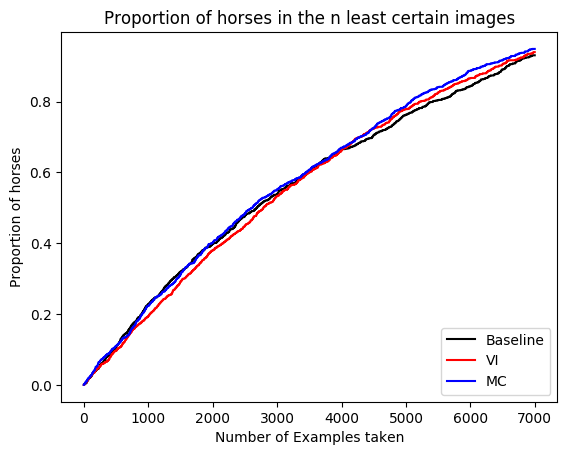

In [87]:

#what is the proportion of horses if we take the 7000 least certain images

nr_of_samples=7000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  #
plt.plot(proportion_of_horses,c="black")
plt.title('Proportion of horses in the n least certain images')
plt.ylabel('Proportion of horses')
plt.xlabel('Number of Examples taken')


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy[i] = -np.sum( pred_means[i] * np.log2(pred_means[i] + 1E-14)) #Numerical Stability

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
plt.plot(proportion_of_horses,c="red")


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  
plt.plot(proportion_of_horses,c="blue")
plt.legend(['Baseline', 'VI',"MC"], loc='lower right')
plt.show()







### Use the entropy and the total standart deviation as a filter?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the code for the filtering and use the predicted entropy and the standart deviation as a filter. Note that a high value for the entropy and the standart deviation means the prediction is uncertain. Which model has the best accuracy if we take the best 3000 predictions?*